In [1]:
!pip install wurlitzer

In [2]:
!pip uninstall tensorflow tensorflow-decision-forests --yes


Found existing installation: tensorflow 2.15.0
Uninstalling tensorflow-2.15.0:
  Successfully uninstalled tensorflow-2.15.0
Found existing installation: tensorflow-decision-forests 1.8.1
Uninstalling tensorflow-decision-forests-1.8.1:
  Successfully uninstalled tensorflow-decision-forests-1.8.1


In [3]:
!pip install tensorflow[and-cuda]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.6/412.6 MB 3.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 86.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.0/22.0 MB 72.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.9/24.9 MB 69.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 867.7/867.7 kB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 704.7/704.7 MB 1.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 MB 16.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 MB 12.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.5/197.5 MB 8.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 9.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━

In [4]:
import tensorflow as tf
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.layers import Flatten, Dense, Input
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import LearningRateScheduler
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

In [6]:
train_data_dir = '/kaggle/input/data-set-1/data_set_1/train'
val_data_dir = '/kaggle/input/data-set-1/data_set_1/valid'
test_data_dir = '/kaggle/input/data-set-1/data_set_1/test'

In [7]:
input_shape = (224, 224, 3)

img_width, img_height = 224, 224

batch_size=32

In [8]:
train_dataset = image_dataset_from_directory(
    train_data_dir,
    image_size=(img_width, img_height),
    batch_size= batch_size)

val_dataset = image_dataset_from_directory(
    val_data_dir,
    image_size=(img_width, img_height),
    batch_size= batch_size)

test_dataset = image_dataset_from_directory(
    test_data_dir,
    seed=123,
    image_size=(img_width, img_height),
    batch_size= batch_size)

Found 2366 files belonging to 5 classes.
Found 500 files belonging to 5 classes.
Found 250 files belonging to 5 classes.


In [9]:
class_names = train_dataset.class_names
num_class = len(class_names)
print(f"All class names: {class_names}")
print(f"Number of class names: {num_class}")

for image_batch, labels_batch in train_dataset:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

All class names: ['chair', 'laptop', 'people', 'table', 'watch']
Number of class names: 5
(32, 224, 224, 3)
(32,)


Before augmentation


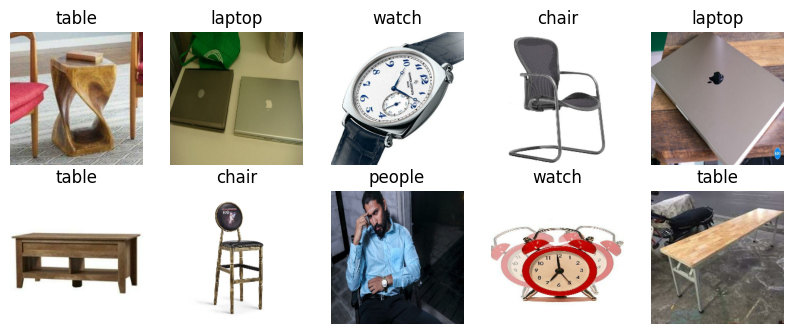

In [10]:
print("Before augmentation")
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(10):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [11]:
def DataProccessing(data, aug=True, nor=True):
    # Xử lý tăng cường dữ liệu
    if aug:
        # Tạo chuỗi các phép biến đổi ngẫu nhiên
        data_augmentation = Sequential([
            RandomFlip('horizontal_and_vertical'),
            RandomRotation(0.2),
            RandomZoom(0.5),
            RandomTranslation(width_factor=0.1, height_factor=0.1),
            RandomContrast(factor=(0.5, 2)),
        ])
        # Áp dụng chuỗi biến đổi lên dữ liệu
        data = data.map(lambda x, y: (data_augmentation(x, training=True), y))
    
    # Chuẩn hóa dữ liệu
    if nor:
        # Tạo lớp chuẩn hóa dữ liệu
        normalization_layer = Rescaling(1./255)
        # Áp dụng lớp chuẩn hóa lên dữ liệu
        data = data.map(lambda x, y: (normalization_layer(x), y))
    
    # Trả về dữ liệu đã được tiền xử lý
    return data

After augmentation


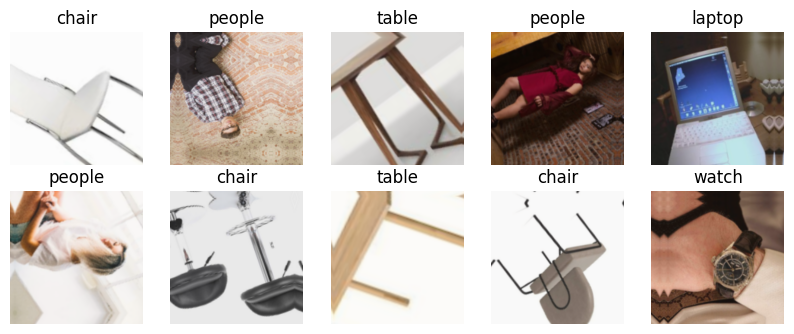

In [12]:
train_aug = DataProccessing(train_dataset , aug=True , nor=False)

print("After augmentation")
plt.figure(figsize=(10, 10))
for images, labels in train_aug.take(1):
    for i in range(10):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [13]:
train_dataset = DataProccessing(train_aug, aug=False, nor=True)
val_dataset = DataProccessing(val_dataset, aug=False, nor=True)
test_dataset = DataProccessing(test_dataset, aug=False, nor=True)

In [14]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# MLP 

In [15]:
mlp_model = Sequential(name="MLP")
mlp_model.add(Flatten(input_shape=(224, 224, 3)))  # Phẳng hóa đầu vào thành vectơ
mlp_model.add(Dense(units=256, activation='relu'))
mlp_model.add(Dense(units=256, activation='relu'))
mlp_model.add(Dense(units=5, activation='softmax'))
mlp_model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "MLP"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    38,535,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,602,501 (147.26 MB)

 Trainable params: 38,602,501 (147.26 MB)

 Non-trainable params: 0 (0.00 B)

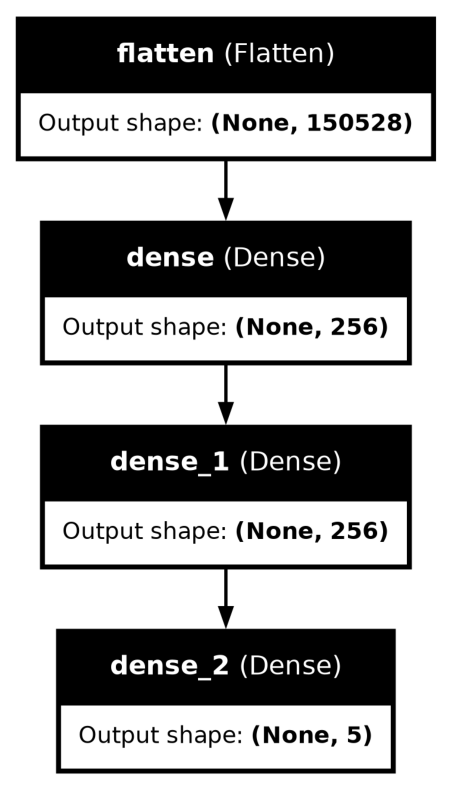

In [16]:
plot_model(mlp_model, to_file='mlp_model_architecture.png', show_shapes=True, show_layer_names=True)
img = plt.imread('mlp_model_architecture.png')
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off') 
plt.show()

In [17]:
# sgd = SGD(learning_rate=0.0001)
mlp_model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),
                   optimizer=Adam(learning_rate=3e-4),
                   metrics=["accuracy"])

checkpoint = ModelCheckpoint("MLP_Classroom_Object_Classifier.keras",
                             monitor='val_accuracy',
                             mode='max',
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=1,
                          mode='max',
                          patience=20,
                          verbose=1,
                          restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.2,
                              patience=5,
                              verbose=1)

callbacks=[checkpoint, reduce_lr]


h_mlp = mlp_model.fit(train_ds,
                      validation_data=val_ds,
                      epochs=100,
                      callbacks=callbacks,
                      verbose=1,
                      shuffle=True)

Epoch 1/100


I0000 00:00:1711962399.195940     118 service.cc:145] XLA service 0x7d8f08009d80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1711962399.195984     118 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


16/74 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2121 - loss: 28.2253

I0000 00:00:1711962400.212163     118 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


71/74 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2250 - loss: 21.6762
Epoch 1: val_accuracy improved from -inf to 0.21400, saving model to MLP_Classroom_Object_Classifier.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 50s 87ms/step - accuracy: 0.2254 - loss: 21.1939 - val_accuracy: 0.2140 - val_loss: 4.1280 - learning_rate: 3.0000e-04
Epoch 2/100
71/74 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3006 - loss: 2.6340
Epoch 2: val_accuracy improved from 0.21400 to 0.28400, saving model to MLP_Classroom_Object_Classifier.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.3003 - loss: 2.6351 - val_accuracy: 0.2840 - val_loss: 2.8456 - learning_rate: 3.0000e-04
Epoch 3/100
71/74 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3273 - loss: 2.7775
Epoch 3: val_accuracy did not improve from 0.28400
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3267 - loss: 2.7585 - val_accuracy: 0.1880 - val_loss: 2.4625 - learning_rate: 3.0000e-04
Epoch 4/100
71/74 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

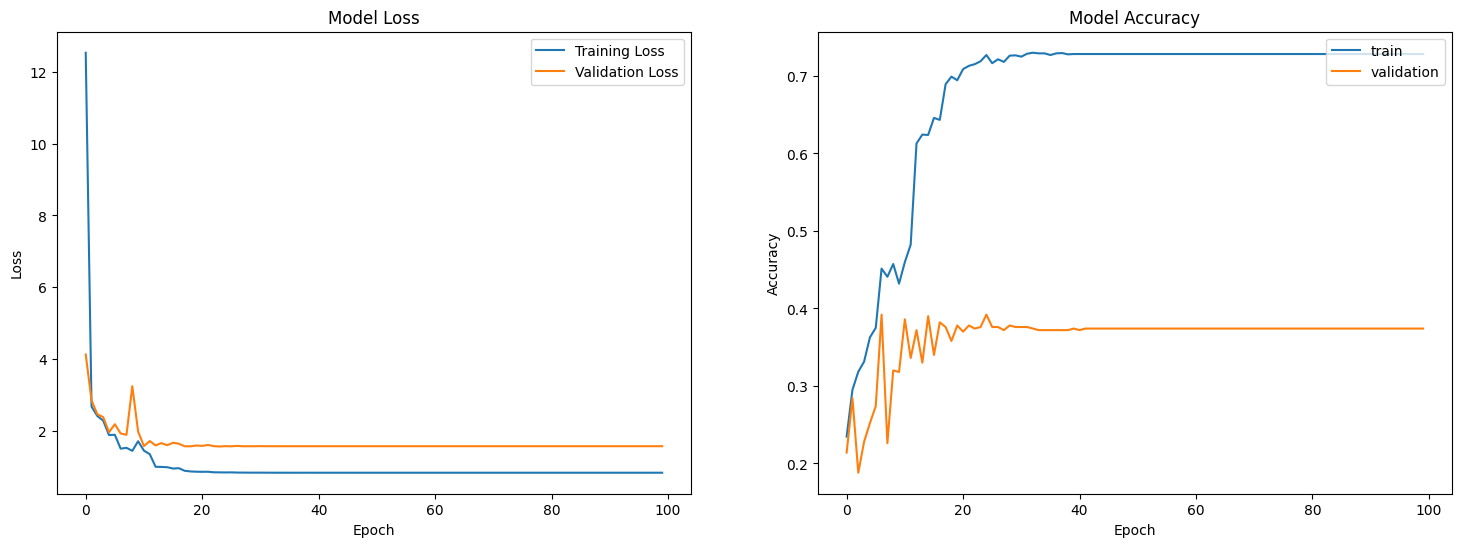

In [18]:
plt.figure(figsize=(18,6))
# Biểu đồ loss
plt.subplot(1, 2, 1)
plt.plot(h_mlp.history['loss'], label='Training Loss')
plt.plot(h_mlp.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Biểu đồ accuracy
plt.subplot(1, 2, 2)
plt.plot(h_mlp.history['accuracy'], )
plt.plot(h_mlp.history['val_accuracy'], )
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'], loc='upper right')

plt.show()

In [19]:
mlp_model.load_weights('./MLP_Classroom_Object_Classifier.keras')
score = mlp_model.evaluate(test_dataset, verbose=0)
print(f"Test accuracy: {score[1] * 100}%")

Test accuracy: 39.59999978542328%


# CNN

In [20]:
cnn_model = Sequential(name="CNN")

cnn_model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('relu'))
cnn_model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Dropout(0.25))


cnn_model.add(Conv2D(64, (3, 3), padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('relu'))
cnn_model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Dropout(0.3))


cnn_model.add(Conv2D(128, (3, 3), padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('relu'))
cnn_model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Dropout(0.35))


cnn_model.add(Flatten())
cnn_model.add(Dense(256))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('relu'))
cnn_model.add(Dropout(0.4))
cnn_model.add(Dense(5, activation='softmax'))
cnn_model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             

 Total params: 25,980,581 (99.11 MB)

 Trainable params: 25,979,621 (99.10 MB)

 Non-trainable params: 960 (3.75 KB)

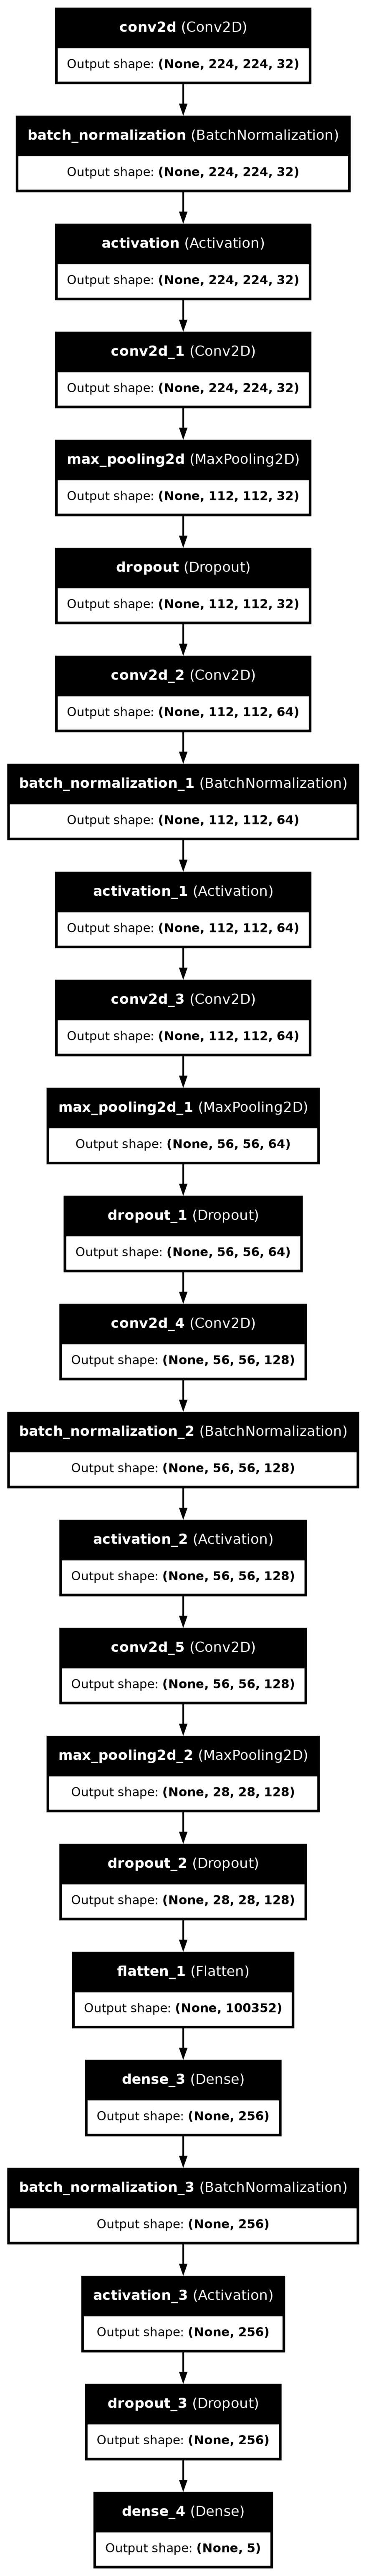

In [21]:
plot_model(cnn_model, to_file='cnn_model_architecture.png', show_shapes=True, show_layer_names=True)
img = plt.imread('cnn_model_architecture.png')
plt.figure(figsize=(40, 80))
plt.imshow(img)
plt.axis('off') 
plt.show()

In [22]:
# sgd = SGD(learning_rate=0.0001)
cnn_model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),
                   optimizer=Adam(learning_rate=3e-4),
                   metrics=["accuracy"])

checkpoint = ModelCheckpoint("CNN_Classroom_Object_Classifier.keras",
                             monitor='val_accuracy',
                             mode='max',
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=1,
                          mode='max',
                          patience=20,
                          verbose=1,
                          restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.2,
                              patience=5,
                              verbose=1)

callbacks=[checkpoint, reduce_lr]


h_cnn = cnn_model.fit(train_ds,
                      validation_data=val_ds,
                      epochs=100,
                      callbacks=callbacks,
                      verbose=1,
                      shuffle=True)

Epoch 1/100


2024-04-01 09:08:41.937726: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 223: 2.38178, expected 1.97036
2024-04-01 09:08:41.937874: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 11647: 2.9597, expected 2.54828
2024-04-01 09:08:41.938203: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 49971: 3.08701, expected 2.67559
2024-04-01 09:08:41.938240: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 50014: 3.10933, expected 2.69791
2024-04-01 09:08:41.938258: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 50067: 2.78437, expected 2.37294
2024-04-01 09:08:41.938270: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 50069: 3.10014, expected 2.68872
2024-04-01 09:08:41.938282: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 50091: 3.11025, expected 2.69882
2024-04-01 09:08:41.938293: E externa

 2/74 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.2031 - loss: 2.3483  

I0000 00:00:1711962531.857832     117 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_12', 4 bytes spill stores, 12 bytes spill loads



42/74 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.2994 - loss: 2.0621

2024-04-01 09:08:58.449009: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 0: 3.61233, expected 3.04092
2024-04-01 09:08:58.449071: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 8: 4.46627, expected 3.89485
2024-04-01 09:08:58.449081: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 11: 4.41222, expected 3.84081
2024-04-01 09:08:58.449089: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 12: 3.02418, expected 2.45277
2024-04-01 09:08:58.449096: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 13: 3.88651, expected 3.31509
2024-04-01 09:08:58.449104: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 28: 4.18259, expected 3.61118
2024-04-01 09:08:58.449112: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 29: 3.50085, expected 2.92944
2024-04-01 09:08:58.449119: E external/local_xla/xla/serv

44/74 ━━━━━━━━━━━━━━━━━━━━ 10s 361ms/step - accuracy: 0.3011 - loss: 2.0523

I0000 00:00:1711962547.335670     116 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_1', 4 bytes spill stores, 12 bytes spill loads



74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.3203 - loss: 1.9333

2024-04-01 09:09:10.801930: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 0: 3.90306, expected 3.1331
2024-04-01 09:09:10.802011: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 1: 4.61733, expected 3.84737
2024-04-01 09:09:10.802033: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 2: 5.23399, expected 4.46402
2024-04-01 09:09:10.802046: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 3: 4.26095, expected 3.49098
2024-04-01 09:09:10.802065: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 4: 4.5243, expected 3.75433
2024-04-01 09:09:10.802076: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 5: 5.66323, expected 4.89327
2024-04-01 09:09:10.802086: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 6: 4.71731, expected 3.94734
2024-04-01 09:09:10.802096: E external/local_xla/xla/service/gpu


Epoch 1: val_accuracy improved from -inf to 0.20200, saving model to CNN_Classroom_Object_Classifier.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 39s 298ms/step - accuracy: 0.3209 - loss: 1.9302 - val_accuracy: 0.2020 - val_loss: 2.1322 - learning_rate: 3.0000e-04
Epoch 2/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.5480 - loss: 1.1974
Epoch 2: val_accuracy did not improve from 0.20200
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.5477 - loss: 1.1980 - val_accuracy: 0.2000 - val_loss: 2.7160 - learning_rate: 3.0000e-04
Epoch 3/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.5919 - loss: 1.0277
Epoch 3: val_accuracy improved from 0.20200 to 0.21000, saving model to CNN_Classroom_Object_Classifier.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.5920 - loss: 1.0279 - val_accuracy: 0.2100 - val_loss: 2.8777 - learning_rate: 3.0000e-04
Epoch 4/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7033 - loss: 0.8070
Epoch 4: val_accuracy improved from 0.2

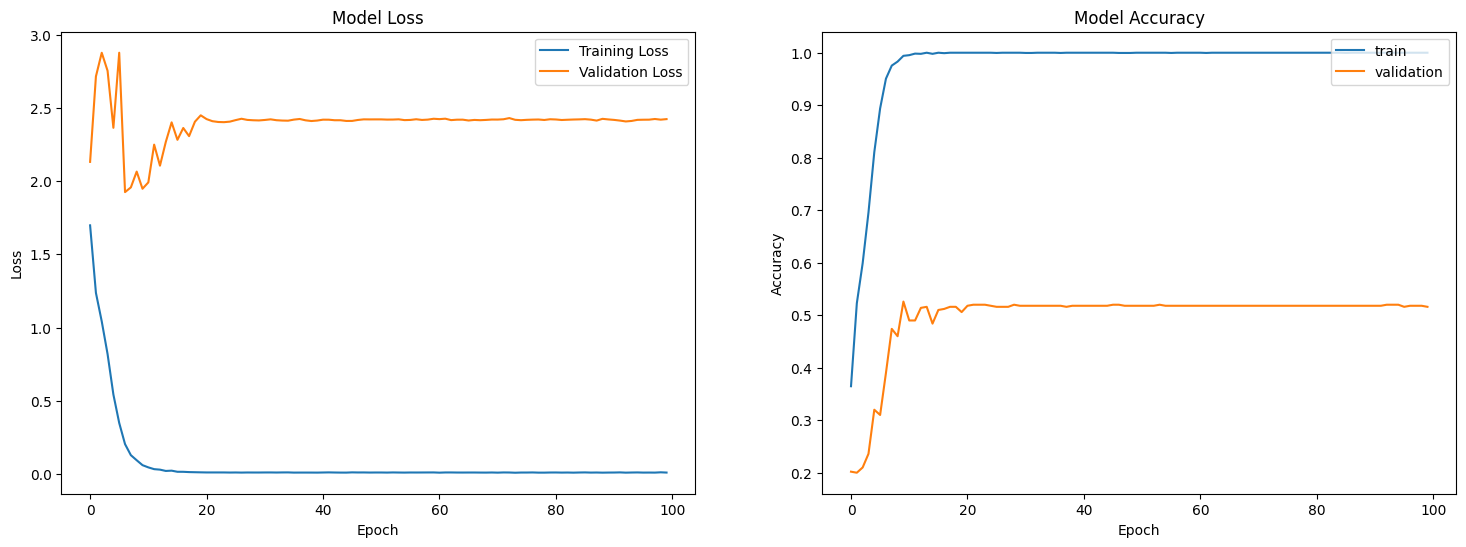

In [23]:
plt.figure(figsize=(18,6))
# Biểu đồ loss
plt.subplot(1, 2, 1)
plt.plot(h_cnn.history['loss'], label='Training Loss')
plt.plot(h_cnn.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Biểu đồ accuracy
plt.subplot(1, 2, 2)
plt.plot(h_cnn.history['accuracy'], )
plt.plot(h_cnn.history['val_accuracy'], )
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'], loc='upper right')

plt.show()

In [24]:

cnn_model.load_weights('./CNN_Classroom_Object_Classifier.keras')
score = cnn_model.evaluate(test_dataset, verbose=0)
print(f"Test accuracy: {score[1] * 100}%")

2024-04-01 09:18:15.267386: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 50176: 4.09386, expected 3.19596
2024-04-01 09:18:15.267452: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 50177: 5.49103, expected 4.59314
2024-04-01 09:18:15.267466: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 50178: 5.14947, expected 4.25158
2024-04-01 09:18:15.267480: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 50179: 4.65731, expected 3.75942
2024-04-01 09:18:15.267498: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 50180: 5.19248, expected 4.29459
2024-04-01 09:18:15.267511: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 50181: 4.9954, expected 4.0975
2024-04-01 09:18:15.267521: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 50182: 4.4422, expected 3.5443
2024-04-01 09:18:15.267532: E external

Test accuracy: 46.799999475479126%


# VGG16

In [25]:
def VGG16():
    vgg16_model = Sequential(name="VGG16")

        # Khối VGG 1
    vgg16_model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', input_shape=input_shape, name='Conv2D'))
    vgg16_model.add(BatchNormalization())
    vgg16_model.add(Activation('relu'))
    vgg16_model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same',  name='Conv2D_1'))
    vgg16_model.add(BatchNormalization())
    vgg16_model.add(Activation('relu'))
    vgg16_model.add(MaxPool2D(pool_size=2, strides=2, name='MaxPooling2D'))
    vgg16_model.add(Dropout(0.1))

        # Khối VGG 2
    vgg16_model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', name='Conv2D_2'))
    vgg16_model.add(BatchNormalization())
    vgg16_model.add(Activation('relu'))
    vgg16_model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same',  name='Conv2D_3'))
    vgg16_model.add(BatchNormalization())
    vgg16_model.add(Activation('relu'))
    vgg16_model.add(MaxPool2D(pool_size=2, strides=2, name='MaxPooling2D_1'))
    vgg16_model.add(Dropout(0.2))

        # Khối VGG 3
    vgg16_model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same',   name='Conv2D_4'))
    vgg16_model.add(BatchNormalization())
    vgg16_model.add(Activation('relu'))
    vgg16_model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same',   name='Conv2D_5'))
    vgg16_model.add(BatchNormalization())
    vgg16_model.add(Activation('relu'))
    vgg16_model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu', name='Conv2D_6'))
    vgg16_model.add(MaxPool2D(pool_size=2, strides=2, name='MaxPooling2D_2'))
    vgg16_model.add(Dropout(0.3))

        # Khối VGG 4
    vgg16_model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same',  name='Conv2D_7'))
    vgg16_model.add(BatchNormalization())
    vgg16_model.add(Activation('relu'))
    vgg16_model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', name='Conv2D_8'))
    vgg16_model.add(BatchNormalization())
    vgg16_model.add(Activation('relu'))
    vgg16_model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same',  name='Conv2D_9'))
    vgg16_model.add(BatchNormalization())
    vgg16_model.add(Activation('relu'))
    vgg16_model.add(MaxPool2D(pool_size=2, strides=2, name='MaxPooling2D_3'))
    vgg16_model.add(Dropout(0.4))

        # Khối VGG 5
    vgg16_model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same',  name='Conv2D_10'))
    vgg16_model.add(BatchNormalization())
    vgg16_model.add(Activation('relu'))
    vgg16_model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same',  name='Conv2D_11'))
    vgg16_model.add(BatchNormalization())
    vgg16_model.add(Activation('relu'))
    vgg16_model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same',  name='Conv2D_12'))
    vgg16_model.add(BatchNormalization())
    vgg16_model.add(Activation('relu'))
    vgg16_model.add(MaxPool2D(pool_size=2, strides=2, name='MaxPooling2D_4'))
    vgg16_model.add(Dropout(0.5))

        # fully connected layer
    vgg16_model.add(Flatten(name='Flatten'))
    vgg16_model.add(Dense(4096, activation='relu',name='Dense'))
    vgg16_model.add(Dropout(0.6, name='Dropout'))
    vgg16_model.add(Dense(4096, activation='relu',name='Dense_1'))
    vgg16_model.add(Dropout(0.7, name='Dropout_1'))
    vgg16_model.add(Dense(5 , activation='softmax'))
    
    return vgg16_model



In [26]:
vgg_16_model = VGG16()
print(vgg_16_model.summary())

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "VGG16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv2D (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 224, 224, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_1 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 224, 224, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling2D (MaxPooling2D)     │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_2 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_3 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling2D_1 (MaxPooling2D)   │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_4 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 56, 56, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_5 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 56, 56, 256)    │             

 Total params: 134,296,901 (512.30 MB)

 Trainable params: 134,288,965 (512.27 MB)

 Non-trainable params: 7,936 (31.00 KB)

None


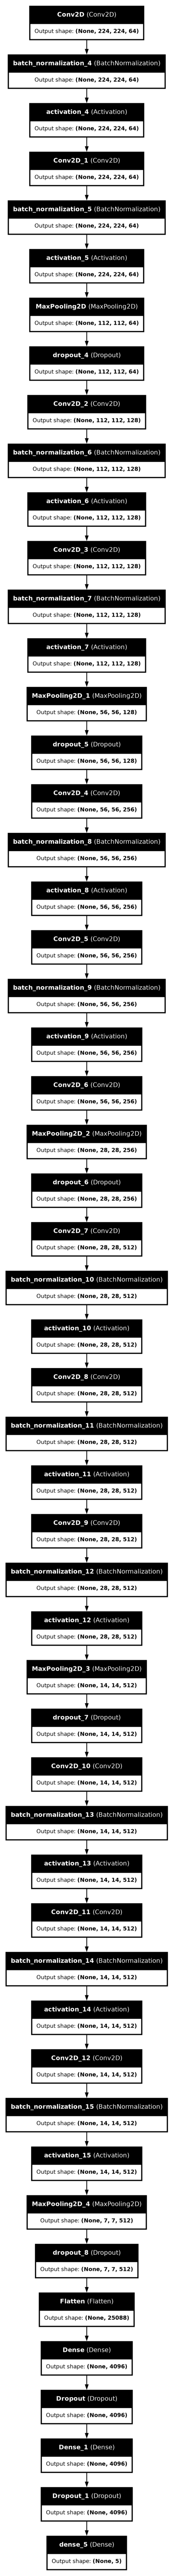

In [27]:
plot_model(vgg_16_model, to_file='vgg_16_model_architecture.png', show_shapes=True, show_layer_names=True)
img = plt.imread('vgg_16_model_architecture.png')
plt.figure(figsize=(40, 80))
plt.imshow(img)
plt.axis('off') 
plt.show()

In [28]:
# sgd = SGD(learning_rate=0.0001)
vgg_16_model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),
                   optimizer=Adam(learning_rate=3e-4),
                   metrics=["accuracy"])

checkpoint = ModelCheckpoint("VGG16_Classroom_Object_Classifier.keras",
                             monitor='val_accuracy',
                             mode='max',
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=1,
                          mode='max',
                          patience=20,
                          verbose=1,
                          restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.2,
                              patience=5,
                              verbose=1)

callbacks=[checkpoint, reduce_lr]


h_vgg16 = vgg_16_model.fit(train_ds,
                      validation_data=val_ds,
                      epochs=100,
                      callbacks=callbacks,
                      verbose=1,
                      shuffle=True)

Epoch 1/100


2024-04-01 09:18:40.613946: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 0: 4.63498, expected 3.85968
2024-04-01 09:18:40.614021: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 3: 6.55784, expected 5.78254
2024-04-01 09:18:40.614031: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 4: 6.61282, expected 5.83752
2024-04-01 09:18:40.614039: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 6: 6.34499, expected 5.56968
2024-04-01 09:18:40.614047: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 7: 6.25159, expected 5.47629
2024-04-01 09:18:40.614055: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 8: 5.43964, expected 4.66434
2024-04-01 09:18:40.614062: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 9: 6.54333, expected 5.76803
2024-04-01 09:18:40.614070: E external/local_xla/xla/service/g

68/74 ━━━━━━━━━━━━━━━━━━━━ 1s 258ms/step - accuracy: 0.1982 - loss: 11.5256

2024-04-01 09:19:29.829088: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 50176: 5.1593, expected 4.2307
2024-04-01 09:19:29.829147: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 50177: 5.27465, expected 4.34605
2024-04-01 09:19:29.829156: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 50178: 6.22507, expected 5.29647
2024-04-01 09:19:29.829164: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 50179: 6.11698, expected 5.18838
2024-04-01 09:19:29.829172: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 50180: 5.57882, expected 4.65022
2024-04-01 09:19:29.829181: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 50181: 5.26032, expected 4.33172
2024-04-01 09:19:29.829189: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 50182: 5.05778, expected 4.12918
2024-04-01 09:19:29.829197: E extern

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 670ms/step - accuracy: 0.1978 - loss: 11.2906

2024-04-01 09:19:56.923452: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 50176: 3.79983, expected 3.15789
2024-04-01 09:19:56.923515: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 50177: 5.13466, expected 4.49272
2024-04-01 09:19:56.923525: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 50178: 4.78155, expected 4.13961
2024-04-01 09:19:56.923533: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 50179: 4.88295, expected 4.24101
2024-04-01 09:19:56.923540: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 50180: 4.73279, expected 4.09085
2024-04-01 09:19:56.923548: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 50181: 4.69943, expected 4.05749
2024-04-01 09:19:56.923556: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 50182: 4.1975, expected 3.55556
2024-04-01 09:19:56.923564: E exter


Epoch 1: val_accuracy improved from -inf to 0.18600, saving model to VGG16_Classroom_Object_Classifier.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 104s 875ms/step - accuracy: 0.1978 - loss: 11.2531 - val_accuracy: 0.1860 - val_loss: 1.8871 - learning_rate: 3.0000e-04
Epoch 2/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.2068 - loss: 5.4886
Epoch 2: val_accuracy improved from 0.18600 to 0.20000, saving model to VGG16_Classroom_Object_Classifier.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 27s 364ms/step - accuracy: 0.2068 - loss: 5.4821 - val_accuracy: 0.2000 - val_loss: 2.5193 - learning_rate: 3.0000e-04
Epoch 3/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.2035 - loss: 2.2711
Epoch 3: val_accuracy improved from 0.20000 to 0.21400, saving model to VGG16_Classroom_Object_Classifier.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 27s 363ms/step - accuracy: 0.2038 - loss: 2.2711 - val_accuracy: 0.2140 - val_loss: 1.5864 - learning_rate: 3.0000e-04
Epoch 4/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step

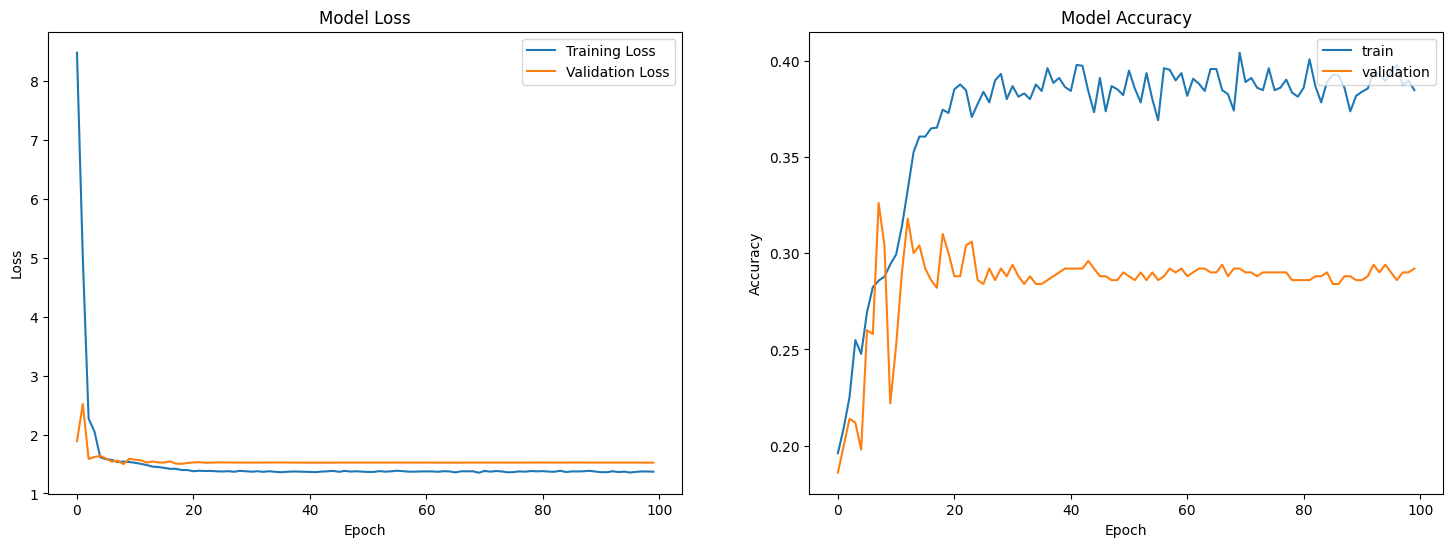

In [29]:
plt.figure(figsize=(18,6))
# Biểu đồ loss
plt.subplot(1, 2, 1)
plt.plot(h_vgg16.history['loss'], label='Training Loss') 
plt.plot(h_vgg16.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Biểu đồ accuracy
plt.subplot(1, 2, 2)
plt.plot(h_vgg16.history['accuracy'], )
plt.plot(h_vgg16.history['val_accuracy'], )
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'], loc='upper right')

plt.show()

In [30]:
vgg_16_model.load_weights('./VGG16_Classroom_Object_Classifier.keras')
score = vgg_16_model.evaluate(test_dataset, verbose=0)
print(f"Test accuracy: {score[1] * 100}%")

2024-04-01 09:54:47.623983: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 0: 3.46443, expected 2.59124
2024-04-01 09:54:47.624049: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 1: 4.84232, expected 3.96913
2024-04-01 09:54:47.624058: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 2: 4.91526, expected 4.04207
2024-04-01 09:54:47.624067: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 3: 5.02814, expected 4.15494
2024-04-01 09:54:47.624074: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 4: 4.53562, expected 3.66243
2024-04-01 09:54:47.624082: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 5: 4.79722, expected 3.92403
2024-04-01 09:54:47.624089: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 6: 4.69349, expected 3.82029
2024-04-01 09:54:47.624097: E external/local_xla/xla/service/g

Test accuracy: 27.59999930858612%


#  Transfer learning VGG16

In [31]:
from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Model
from tensorflow.keras import layers

def Transfer_learning_VGG16():
    # Tải mô hình VGG16 đã được huấn luyện trước
    vgg16_trl = vgg16.VGG16(weights='imagenet',pooling='max', include_top=False, input_shape=input_shape)

    # Đóng băng các lớp của mô hình VGG16
    for layer in vgg16_trl.layers:
        layer.trainable = False

    # Thêm các lớp mới cho mô hình
    x = vgg16_trl.output
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x) 
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x) 
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x) 
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation='relu')(x) 
    x = layers.Dropout(0.5)(x)

    predictions = layers.Dense(5, activation='softmax')(x)

    # Tạo mô hình hoàn chỉnh
    vgg16_trl_model = Model(inputs=vgg16_trl.input, outputs=predictions)
    
    return vgg16_trl_model



In [32]:
# Sử dụng hàm để tạo mô hình
vgg_16_trl_model = Transfer_learning_VGG16()
print(vgg_16_trl_model.summary())

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_83"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 512)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 15,150,149 (57.79 MB)

 Trainable params: 435,461 (1.66 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


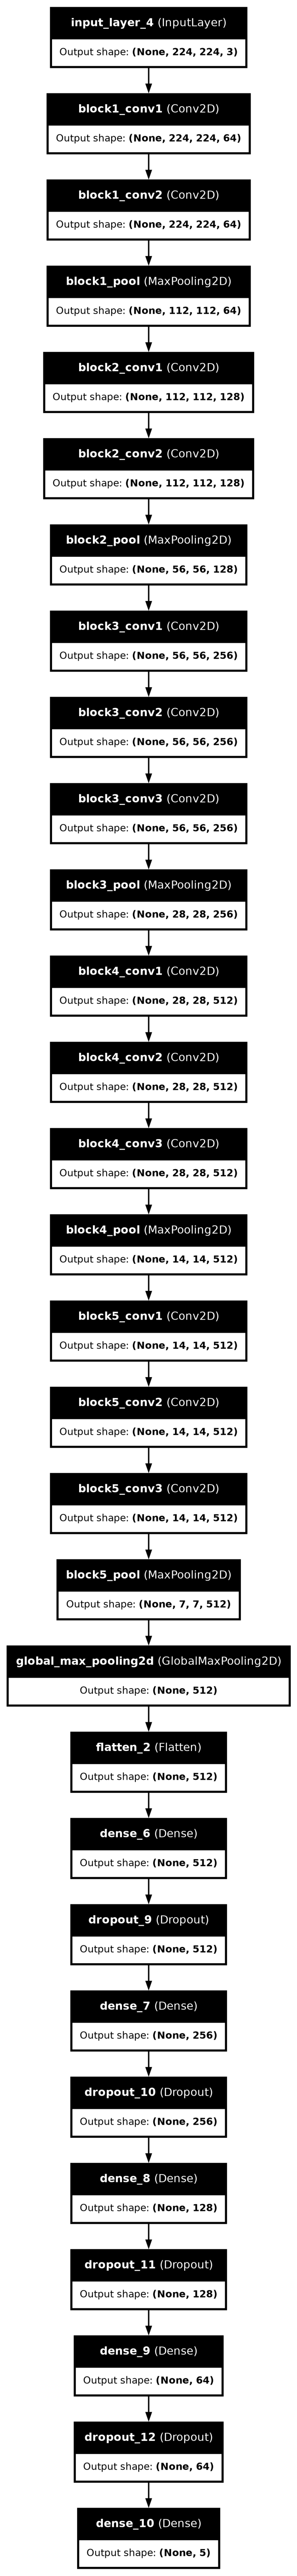

In [33]:
plot_model(vgg_16_trl_model, to_file='vgg_16_trl_model_architecture.png', show_shapes=True, show_layer_names=True)
img = plt.imread('vgg_16_trl_model_architecture.png')
plt.figure(figsize=(40, 80))
plt.imshow(img)
plt.axis('off') 
plt.show()

In [34]:
# sgd = SGD(learning_rate=0.0001)
vgg_16_trl_model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),
                   optimizer=Adam(learning_rate=3e-4),
                   metrics=["accuracy"])

checkpoint = ModelCheckpoint("VGG16_trl_Classroom_Object_Classifier.keras",
                             monitor='val_accuracy',
                             mode='max',
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=1,
                          mode='max',
                          patience=20,
                          verbose=1,
                          restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.2,
                              patience=5,
                              verbose=1)

callbacks=[checkpoint, reduce_lr]


h_vgg16_trl = vgg_16_trl_model.fit(train_ds,
                      validation_data=val_ds,
                      epochs=100,
                      callbacks=callbacks,
                      verbose=1,
                      shuffle=True)

Epoch 1/100


2024-04-01 09:55:04.148550: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 0: 4.63498, expected 3.85968
2024-04-01 09:55:04.148607: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 3: 6.55784, expected 5.78254
2024-04-01 09:55:04.148616: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 4: 6.61282, expected 5.83752
2024-04-01 09:55:04.148624: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 6: 6.34499, expected 5.56968
2024-04-01 09:55:04.148632: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 7: 6.25159, expected 5.47629
2024-04-01 09:55:04.148640: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 8: 5.43964, expected 4.66434
2024-04-01 09:55:04.148648: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 9: 6.54333, expected 5.76803
2024-04-01 09:55:04.148655: E external/local_xla/xla/service/g

28/74 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.2164 - loss: 2.8320

2024-04-01 09:55:19.800044: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 50176: 5.1593, expected 4.2307
2024-04-01 09:55:19.800100: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 50177: 5.27465, expected 4.34605
2024-04-01 09:55:19.800109: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 50178: 6.22507, expected 5.29647
2024-04-01 09:55:19.800117: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 50179: 6.11698, expected 5.18838
2024-04-01 09:55:19.800125: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 50180: 5.57882, expected 4.65022
2024-04-01 09:55:19.800133: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 50181: 5.26032, expected 4.33172
2024-04-01 09:55:19.800141: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 50182: 5.05778, expected 4.12918
2024-04-01 09:55:19.800148: E extern

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.2170 - loss: 2.4235

2024-04-01 09:55:36.091584: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 50176: 3.79983, expected 3.15789
2024-04-01 09:55:36.091637: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 50177: 5.13466, expected 4.49272
2024-04-01 09:55:36.091647: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 50178: 4.78155, expected 4.13961
2024-04-01 09:55:36.091654: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 50179: 4.88295, expected 4.24101
2024-04-01 09:55:36.091662: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 50180: 4.73279, expected 4.09085
2024-04-01 09:55:36.091670: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 50181: 4.69943, expected 4.05749
2024-04-01 09:55:36.091677: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 50182: 4.1975, expected 3.55556
2024-04-01 09:55:36.091685: E exter


Epoch 1: val_accuracy improved from -inf to 0.31000, saving model to VGG16_trl_Classroom_Object_Classifier.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 43s 367ms/step - accuracy: 0.2171 - loss: 2.4184 - val_accuracy: 0.3100 - val_loss: 1.5644 - learning_rate: 3.0000e-04
Epoch 2/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.2596 - loss: 1.6445
Epoch 2: val_accuracy improved from 0.31000 to 0.39600, saving model to VGG16_trl_Classroom_Object_Classifier.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.2597 - loss: 1.6440 - val_accuracy: 0.3960 - val_loss: 1.4788 - learning_rate: 3.0000e-04
Epoch 3/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.3199 - loss: 1.5069
Epoch 3: val_accuracy improved from 0.39600 to 0.45400, saving model to VGG16_trl_Classroom_Object_Classifier.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.3201 - loss: 1.5066 - val_accuracy: 0.4540 - val_loss: 1.3667 - learning_rate: 3.0000e-04
Epoch 4/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/s

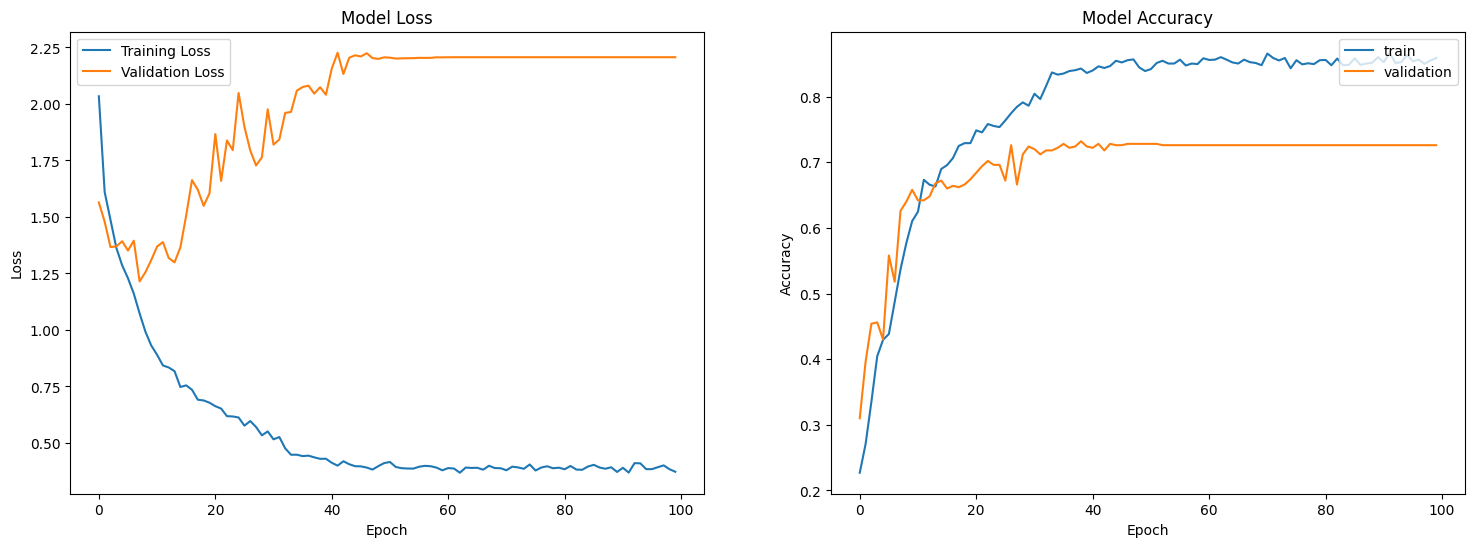

In [35]:
plt.figure(figsize=(18,6))
# Biểu đồ loss
plt.subplot(1, 2, 1)
plt.plot(h_vgg16_trl.history['loss'], label='Training Loss')
plt.plot(h_vgg16_trl.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Biểu đồ accuracy
plt.subplot(1, 2, 2)
plt.plot(h_vgg16_trl.history['accuracy'], )
plt.plot(h_vgg16_trl.history['val_accuracy'], )
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'], loc='upper right')

plt.show()

In [36]:
vgg_16_trl_model.load_weights('./VGG16_trl_Classroom_Object_Classifier.keras')
score = vgg_16_trl_model.evaluate(test_dataset, verbose=0)
print(f"Test accuracy: {score[1] * 100}%")

2024-04-01 10:05:43.633475: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 0: 3.46443, expected 2.59124
2024-04-01 10:05:43.633537: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 1: 4.84232, expected 3.96913
2024-04-01 10:05:43.633548: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 2: 4.91526, expected 4.04207
2024-04-01 10:05:43.633556: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 3: 5.02814, expected 4.15494
2024-04-01 10:05:43.633565: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 4: 4.53562, expected 3.66243
2024-04-01 10:05:43.633573: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 5: 4.79722, expected 3.92403
2024-04-01 10:05:43.633582: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 6: 4.69349, expected 3.82029
2024-04-01 10:05:43.633590: E external/local_xla/xla/service/g

Test accuracy: 72.79999852180481%
